In [1]:
from ecell4 import *
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
rng = GSLRandomNumberGenerator()
import scipy.special

In [9]:
voxelr = 0.005
L = 0.5
V=L**3
Da = 10.
Db = 0.
kD = 4*3.14*2*voxelr*Da
print kD
ka = 1*kD
tmol = 2*voxelr*voxelr/3./Da
tb = (0.5*0.5*L*L)/6./Da #time to boundary
print 'tmol',tmol,tb,tb/tmol
pacc = ka/6./(2**0.5)/Da/voxelr
P = 1. #must be less then one
print 'pacc',pacc
totalpreb = 1./(1+kD/ka)
print 'totalpreb',totalpreb
alpha = 1./pacc
print 'alpha',alpha
#prebt = (1+math.exp(tmol)*(scipy.special.erf(math.sqrt(tmol))-1))/(1+kD/ka)
#print prebt

1.256
tmol 1.66666666667e-06 0.00104166666667 625.0
pacc 2.96042039057
totalpreb 0.5
alpha 0.337789863624


In [10]:
print tmol/((voxelr*2)**2 /Da/(1+ka/kD)**2)
print 0.5265*totalpreb

0.666666666667
0.26325


In [11]:
prebt =0.263
lamda = -np.log(1-prebt)/tmol

In [12]:
def create_model_spa(Da,Db,voxelr,k): 
    with species_attributes():
        A | {'D': str(Da), 'radius':str(voxelr)}        
    return get_model()

In [13]:
#spatio
def rant():
    return np.random.exponential(1/lamda)  

def spa_singlerun():
    model = create_model_spa(Da,Db,voxelr,ka)
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),voxelr,rng)    
    w.bind_to(model)
    (pid,p),suc = w.new_particle(Species("A"),Real3(L*0.5,L*0.5,L*0.5))
    coord = w.position2coordinate(p.position())
    neipos = w.coordinate2position(w.get_neighbor(coord,10))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()    
    duration = tb
    while sim.t() <= duration:
        dt = rant()
        pid,Apos1 = w.get_particle(pid)
        dist = np.array(tuple(Apos1.position()))-np.array(tuple(neipos))
        length = np.linalg.norm(dist)
        diff = length-2*voxelr   
        if (diff<voxelr) and (dt<tmol):
            #print 'neighbor'
            return sim.t()+dt
        else:
            sim.step()  
            pid,Apos2 = w.get_particle(pid)
            dist = np.array(tuple(Apos2.position()))-np.array(tuple(neipos))
            length = np.linalg.norm(dist)
            if (length==0):
                w.remove_particle(pid)
                (pid,p),suc = w.new_particle(Species("A"),Apos1.position())
    return 0

def spa_singlerun2():
    model = create_model_spa(Da,Db,voxelr,ka)
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),voxelr,rng)    
    w.bind_to(model)
    (pid,p),suc = w.new_particle(Species("A"),Real3(L*0.5,L*0.5,L*0.5))
    coord = w.position2coordinate(p.position())
    neipos = w.coordinate2position(w.get_neighbor(coord,10))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.set_alpha(alpha)
    sim.initialize()    
    duration = tb
    while sim.t() <= duration:
        #if (sim.t()==0):
        #    dt = rant()
        #    if (dt<tmol):
        #        return sim.t()+dt     
        #    sim.set_alpha(1.)
        pid,Apos1 = w.get_particle(pid)
        sim.step()  
        #if sim.t()==tmol:
        #    w.remove_particle(pid)
        #    (pid,p),suc = w.new_particle(Species("A"),Real3(L*0.5,L*0.5,L*0.5))        
        #sim.set_alpha(alpha)
        pid,Apos2 = w.get_particle(pid)
        dist = np.array(tuple(Apos2.position()))-np.array(tuple(neipos))
        length = np.linalg.norm(dist)
        if (length==0):
            if (sim.t()>=tmol):
                return sim.t()
            else :
                w.remove_particle(pid)
                (pid,p),suc = w.new_particle(Species("A"),Apos1.position())                
    return 0


In [14]:
rebtime =[]
rng.seed(0)
trial = 10000
for i in range(trial):
    suc = spa_singlerun2()
    if (suc!=0):
        rebtime.append(suc)
        #print i,suc

In [15]:
rebtime = np.array(rebtime)
print min(rebtime),max(rebtime)
print float(len(rebtime))/trial
print float(len(rebtime[rebtime<tmol]))/trial

1.68894931812e-06 0.00103645189822
0.1974
0.0


0.9973


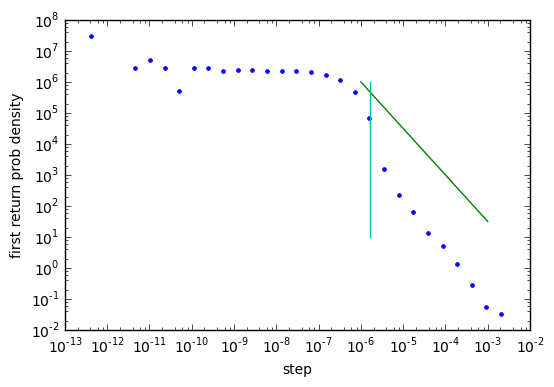

In [31]:
hist, bin_edges = np.histogram(rebtime,bins=np.logspace(np.log10(min(rebtime)),np.log10(max(rebtime)),30))
tt = 0.5*(bin_edges[:-1]+bin_edges[1:])
binwid = -(bin_edges[:-1]-bin_edges[1:])
ft = np.array([float(h)/trial/b for h,b in zip(hist,binwid)])
plt.loglog(tt,ft,'.')
z = lambda x: 1e-3*(x**-1.5) #t^(-0.5)
#w = lambda x: 0.1*(x**-0.5) #t^(-0.5)
plt.plot(np.logspace(-6,-3,50),z(np.logspace(-6,-3,50)),label='p ~ t^-1.5')
#plt.plot(np.logspace(-6,1,50),w(np.logspace(-6,1,50)),'r',label='p ~ t^-0.5')
prange = np.logspace(1,6,10)
plt.plot([tmol]*len(prange),prange,'c')
plt.xlabel('step')
plt.ylabel('first return prob density')
totalsum = sum(ft*binwid)
print totalsum

In [44]:
a = 1.
R = 0.005
l = 2*R
ip1 = 1./1.393
B = (1-ip1)/(1-(1-a)*(1-ip1))
C = 2*a*l*(1-a*B)/math.pi
factor = (1./(1-C/R) -1)/4/math.pi/R/R
print factor

33841.2820553


In [40]:
1-1./1.393

0.2821249102656138

In [43]:
1./(1./2679 +1)

0.9996268656716417

In [60]:
0.5-0.263

0.237

In [61]:
0.91-0.797

0.11299999999999999

In [62]:
0.256+0.263

0.519

In [79]:
(0.5-0.263)/(1-0.263)

0.32157394843962006